# Librerías

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report


# Lectura de los datos

In [ ]:
# Primero se leen los datos y se guardan como un dataframe
df = pd.read_csv("datos_medias_cancer.csv")
pd.set_option('display.max_rows', None)
df.head(5)


,ID,Diagnosis,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave_points,Symmetry,Fractal_dimension
0,842302,1,14.821667,9.538433,105.329667,1057.800000,0.095666,0.330747,0.355243,0.142790,0.244010,0.067934
1,842517,1,15.367833,13.971300,98.366000,1118.693333,0.071255,0.092773,0.115700,0.089857,0.156697,0.049741
2,84300903,1,14.668533,15.855633,95.695000,1002.010000,0.086717,0.208153,0.228707,0.130493,0.196900,0.050714
3,84348301,1,8.941867,16.012000,59.965000,327.010000,0.120470,0.408260,0.328303,0.127123,0.327710,0.093216
4,84358402,1,14.529067,10.597100,97.579333,988.813333,0.083063,0.120803,0.218293,0.095217,0.144953,0.046908


# Regresión Logística


📊 Comparación de métricas en Train vs Test:
     Métrica  Entrenamiento    Prueba
0   Accuracy       0.972362  0.976608
1  Precision       0.972362  0.976741
2     Recall       0.972362  0.976608
3   F1-score       0.972303  0.976531
4        AUC       0.990378  0.998394


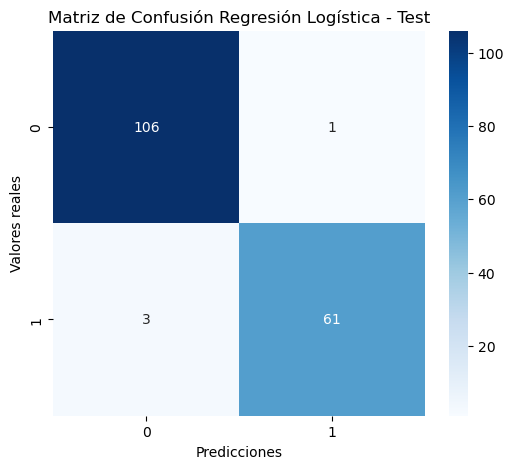

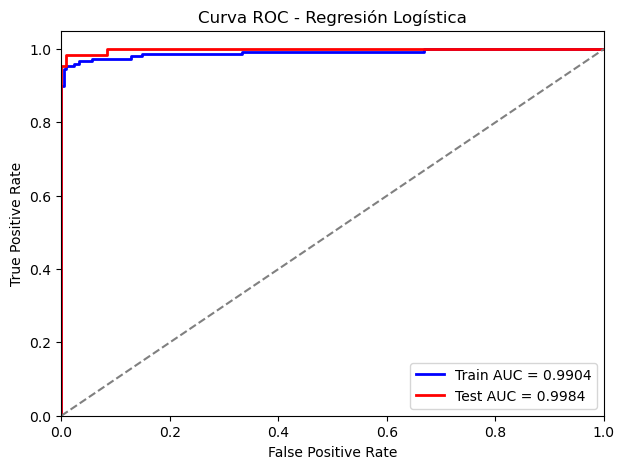


🔍 Coeficientes del modelo (ordenados por importancia):
         Variable  Coeficiente
0          Radius     0.915250
2       Perimeter     0.859453
3            Area     0.847479
1         Texture     0.784391
7  Concave_points     0.700665
4      Smoothness     0.462843
8        Symmetry     0.366239
6       Concavity     0.285720
5     Compactness     0.058859


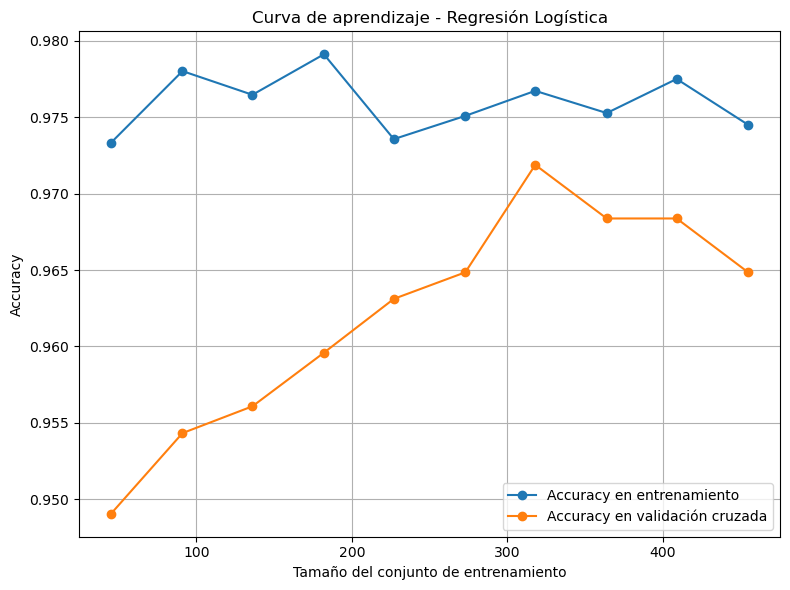

In [ ]:

# Se definen las características y variable objetivo
X = df.drop(columns=['Diagnosis','ID','Fractal_dimension'])  # Reemplaza 'target' por tu variable objetivo
y = df['Diagnosis']

# Se normalizan los datos para Regresión Logística
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Se dividen en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Se inicializa y se entrena el modelo de Regresión Logística
logreg = LogisticRegression(max_iter=100, solver='liblinear', random_state=42, C=0.1, class_weight='balanced')
logreg.fit(X_train, y_train)

# Predicciones en train y test
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

# Probabilidades para ROC-AUC
y_train_probs = logreg.predict_proba(X_train)[:, 1]  # Probabilidad clase positiva
y_test_probs = logreg.predict_proba(X_test)[:, 1]

# Calcular métricas
def calcular_metricas(y_real, y_pred, y_probs):
    acc = accuracy_score(y_real, y_pred)
    prec = precision_score(y_real, y_pred, average='weighted')
    rec = recall_score(y_real, y_pred, average='weighted')
    f1 = f1_score(y_real, y_pred, average='weighted')
    fpr, tpr, _ = roc_curve(y_real, y_probs)
    auc_score = auc(fpr, tpr)
    return acc, prec, rec, f1, auc_score

# Obtener métricas para train y test
train_metrics = calcular_metricas(y_train, y_train_pred, y_train_probs)
test_metrics = calcular_metricas(y_test, y_test_pred, y_test_probs)

# Mostrar métricas en tabla
metricas_df = pd.DataFrame({
    "Métrica": ["Accuracy", "Precision", "Recall", "F1-score", "AUC"],
    "Entrenamiento": train_metrics,
    "Prueba": test_metrics
})

print("\n Comparación de métricas en Train vs Test:")
print(metricas_df)

# Graficar matriz de confusión para TEST
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión Regresión Logística - Test")
plt.show()

# Graficar curva ROC para TRAIN y TEST
plt.figure(figsize=(7,5))
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train AUC = {train_metrics[4]:.4f}')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test AUC = {test_metrics[4]:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal (azar)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.show()


# Curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    logreg, X, y, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy',
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label='Accuracy en entrenamiento')
plt.plot(train_sizes, test_mean, 'o-', label='Accuracy en validación cruzada')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Accuracy')
plt.title('Curva de aprendizaje - Regresión Logística')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Random Forest

     Métrica  Entrenamiento    Prueba
0   Accuracy       0.987437  0.935673
1  Precision       0.987684  0.936274
2     Recall       0.987437  0.935673
3   F1-score       0.987391  0.935099
4        AUC       0.999189  0.956119


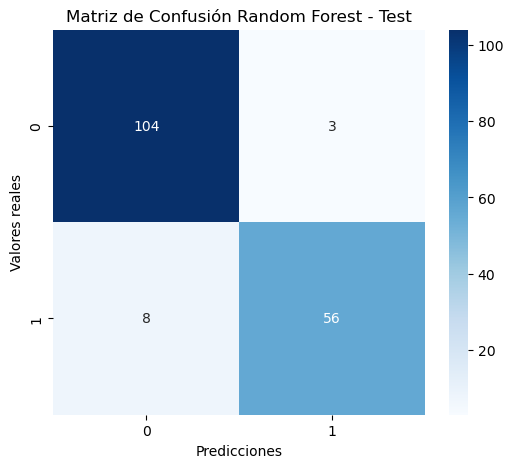

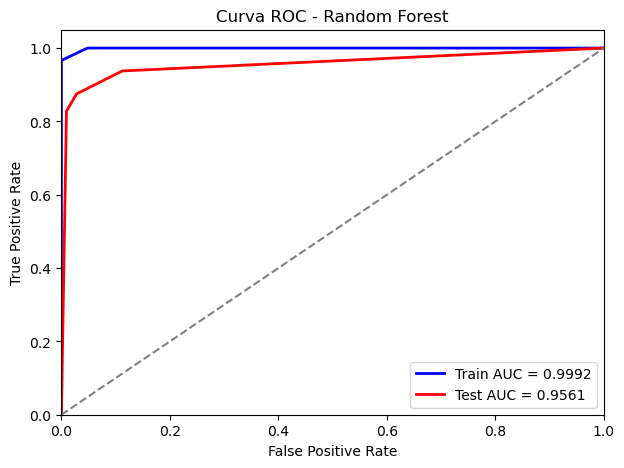


🔍 Importancia de variables según Random Forest:
         Variable  Importancia
2       Perimeter     0.478180
7  Concave_points     0.275612
8        Symmetry     0.072278
3            Area     0.063802
4      Smoothness     0.040554
1         Texture     0.026745
5     Compactness     0.026644
0          Radius     0.010517
6       Concavity     0.005667


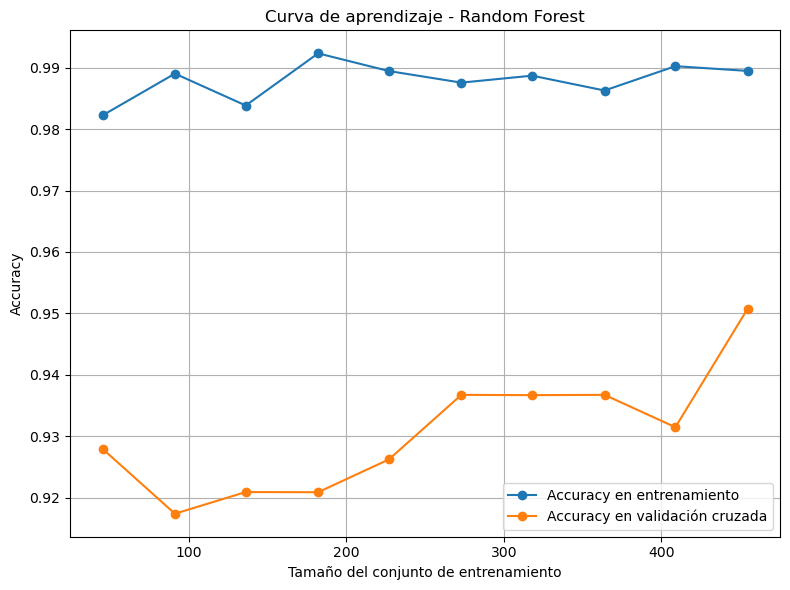

In [ ]:
# Se definen las características y variable objetivo
X = df.drop(columns=['Diagnosis', 'ID','Fractal_dimension'])
y = df['Diagnosis']

# Se dividen los datos en 70% entrenamiento y 30% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Se inicializa y se entrena el modelo Random Forest
rf = RandomForestClassifier(n_estimators=3, random_state=42)
rf.fit(X_train, y_train)

# Predicciones en train y test
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Probabilidades para ROC-AUC
y_train_probs = rf.predict_proba(X_train)[:, 1]  # Probabilidad clase positiva
y_test_probs = rf.predict_proba(X_test)[:, 1]

# Calcular métricas
def calcular_metricas(y_real, y_pred, y_probs):
    acc = accuracy_score(y_real, y_pred)
    prec = precision_score(y_real, y_pred, average='weighted')
    rec = recall_score(y_real, y_pred, average='weighted')
    f1 = f1_score(y_real, y_pred, average='weighted')
    fpr, tpr, _ = roc_curve(y_real, y_probs)
    auc_score = auc(fpr, tpr)
    return acc, prec, rec, f1, auc_score

# Obtener métricas para train y test
train_metrics = calcular_metricas(y_train, y_train_pred, y_train_probs)
test_metrics = calcular_metricas(y_test, y_test_pred, y_test_probs)

# Mostrar métricas
metricas_df = pd.DataFrame({
    "Métrica": ["Accuracy", "Precision", "Recall", "F1-score", "AUC"],
    "Entrenamiento": train_metrics,
    "Prueba": test_metrics
})

print(metricas_df)

# Graficar matriz de confusión para TEST
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión Random Forest - Test")
plt.show()

# Graficar curva ROC para TRAIN y TEST
plt.figure(figsize=(7,5))
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train AUC = {train_metrics[4]:.4f}')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test AUC = {test_metrics[4]:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal (azar)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.show()


# Curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy',
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label='Accuracy en entrenamiento')
plt.plot(train_sizes, test_mean, 'o-', label='Accuracy en validación cruzada')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Accuracy')
plt.title('Curva de aprendizaje - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gradient Boosting


📊 Comparación de métricas en Train vs Test:
     Métrica  Entrenamiento    Prueba
0   Accuracy       0.972362  0.935673
1  Precision       0.973072  0.941669
2     Recall       0.972362  0.935673
3   F1-score       0.972173  0.934221
4        AUC       0.990797  0.977512


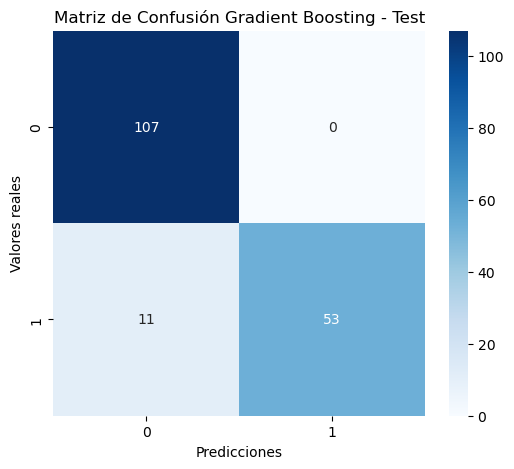

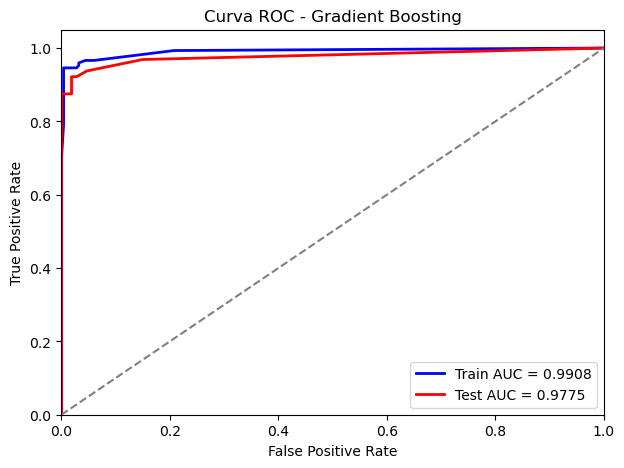


🔍 Importancia de variables según Gradient Boosting:
         Variable  Importancia
7  Concave_points     0.795956
3            Area     0.083342
1         Texture     0.051930
0          Radius     0.047506
2       Perimeter     0.019284
4      Smoothness     0.001448
8        Symmetry     0.000535
5     Compactness     0.000000
6       Concavity     0.000000


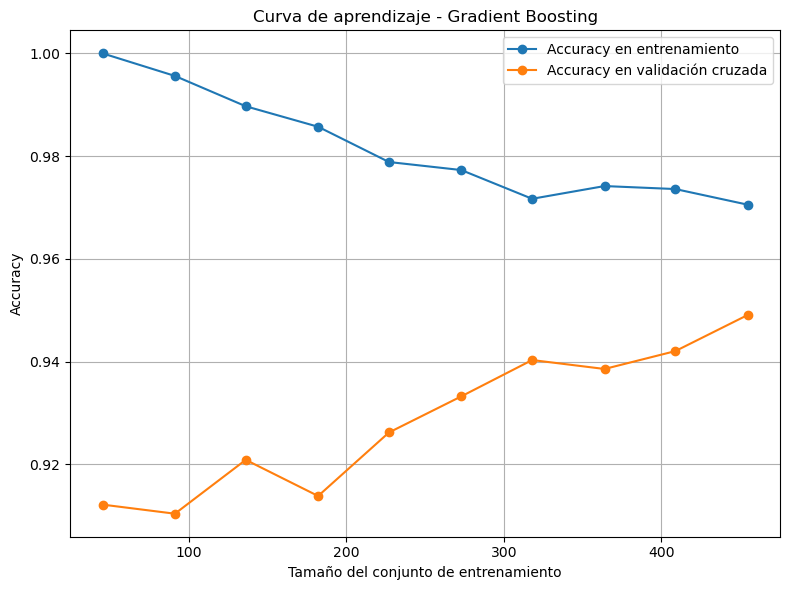

In [ ]:

# Se definen las características y variable objetivo
X = df.drop(columns=['Diagnosis','ID','Fractal_dimension'])  # Reemplaza 'target' por tu variable objetivo
y = df['Diagnosis']

# Se dividen los datos en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Se inicializa y se entrena el modelo de Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=40, learning_rate=0.01, random_state=42)
gb.fit(X_train, y_train)

# Predicciones en train y test
y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)

# Probabilidades para ROC-AUC
y_train_probs = gb.predict_proba(X_train)[:, 1]  # Probabilidad clase positiva
y_test_probs = gb.predict_proba(X_test)[:, 1]

# Calcular métricas
def calcular_metricas(y_real, y_pred, y_probs):
    acc = accuracy_score(y_real, y_pred)
    prec = precision_score(y_real, y_pred, average='weighted')
    rec = recall_score(y_real, y_pred, average='weighted')
    f1 = f1_score(y_real, y_pred, average='weighted')
    fpr, tpr, _ = roc_curve(y_real, y_probs)
    auc_score = auc(fpr, tpr)
    return acc, prec, rec, f1, auc_score

# Obtener métricas para train y test
train_metrics = calcular_metricas(y_train, y_train_pred, y_train_probs)
test_metrics = calcular_metricas(y_test, y_test_pred, y_test_probs)

# Mostrar métricas en tabla
metricas_df = pd.DataFrame({
    "Métrica": ["Accuracy", "Precision", "Recall", "F1-score", "AUC"],
    "Entrenamiento": train_metrics,
    "Prueba": test_metrics
})

print("\n Comparación de métricas en Train vs Test:")
print(metricas_df)

# Graficar matriz de confusión para TEST
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión Gradient Boosting - Test")
plt.show()

# Graficar curva ROC para TRAIN y TEST
plt.figure(figsize=(7,5))
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train AUC = {train_metrics[4]:.4f}')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test AUC = {test_metrics[4]:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal (azar)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Gradient Boosting')
plt.legend(loc='lower right')
plt.show()


# Curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    gb, X, y, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy',
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label='Accuracy en entrenamiento')
plt.plot(train_sizes, test_mean, 'o-', label='Accuracy en validación cruzada')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Accuracy')
plt.title('Curva de aprendizaje - Gradient Boosting')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
